In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import regularizers # Import the 'regularizers' module
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up directory paths
base_dir = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer'
img_path = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/combined_images'
metadata_file = '/content/drive/MyDrive/AI/HAM10000_metadata.csv'
labels_csv='/content/drive/MyDrive/AI/final_labels_df.csv'

In [ ]:
labels_df = pd.read_csv(labels_csv)
image_paths = labels_df['image_id'].values
string_labels = labels_df['dx'].values

# Combine the directory path with the filenames
image_paths = [os.path.join(img_path, filename) for filename in image_paths]

In [ ]:
# Map string labels to integers
label_mapping = {'not melanoma': 0, 'melanoma': 1}
numeric_labels = np.array([label_mapping[label] for label in string_labels])

# Encode labels to one-hot vectors
labels = to_categorical(numeric_labels, num_classes=2)

In [ ]:
# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Parameters
img_height, img_width = 224, 224
batch_size = 32

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    img = load_img(img_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

In [ ]:
def generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            batch_images = np.array([load_and_preprocess_image(img_path) for img_path in batch_paths])
            yield batch_images, batch_labels

In [ ]:
train_generator = generator(train_paths, train_labels, batch_size)
test_generator = generator(test_paths, test_labels, batch_size)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#Compile the model

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 445
Validation steps: 111


In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_steps
)


# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
# Save the entire model to a file
model.save('/content/drive/MyDrive/AI/Skin Cancer/resnet50_melanoma_classifier.keras')

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 5577s 13s/step - accuracy: 0.8645 - loss: 2.0095 - val_accuracy: 0.9307 - val_loss: 1.1184
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 185s 402ms/step - accuracy: 0.9244 - loss: 1.0767 - val_accuracy: 0.9365 - val_loss: 0.9361
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 162s 365ms/step - accuracy: 0.9374 - loss: 0.9038 - val_accuracy: 0.9377 - val_loss: 0.8058
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 155s 349ms/step - accuracy: 0.9406 - loss: 0.7780 - val_accuracy: 0.9408 - val_loss: 0.7044
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 157s 354ms/step - accuracy: 0.9529 - loss: 0.6500 - val_accuracy: 0.9408 - val_loss: 0.6191
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 158s 355ms/step - accuracy: 0.9534 - loss: 0.5644 - val_accuracy: 0.9379 - val_loss: 0.5484
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 158s 355ms/step - accuracy: 0.9602 - loss: 0.4848 - val_accuracy: 0.9433 - val_loss: 0.5092
Epoch 8/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 147s 331ms/step - accuracy: 0.9630 - 

In [ ]:
# Manually extracted values
epochs = list(range(1, 11))  # 10 epochs

# Accuracy values
accuracy = [0.8645, 0.9244, 0.9374, 0.9406, 0.9529, 0.9534, 0.9602, 0.9630, 0.9458, 0.9721]
val_accuracy = [0.9307, 0.9365, 0.9377, 0.9408, 0.9408, 0.9379, 0.9433, 0.9402, 0.9379, 0.9411]

# Loss values
loss = [2.0095, 1.0767, 0.9038, 0.7780, 0.6500, 0.5644, 0.4848, 0.4209, 0.3640, 0.3117]
val_loss = [1.1184, 0.9361, 0.8058, 0.7044, 0.6191, 0.5484, 0.5092, 0.4804, 0.4362, 0.4113]

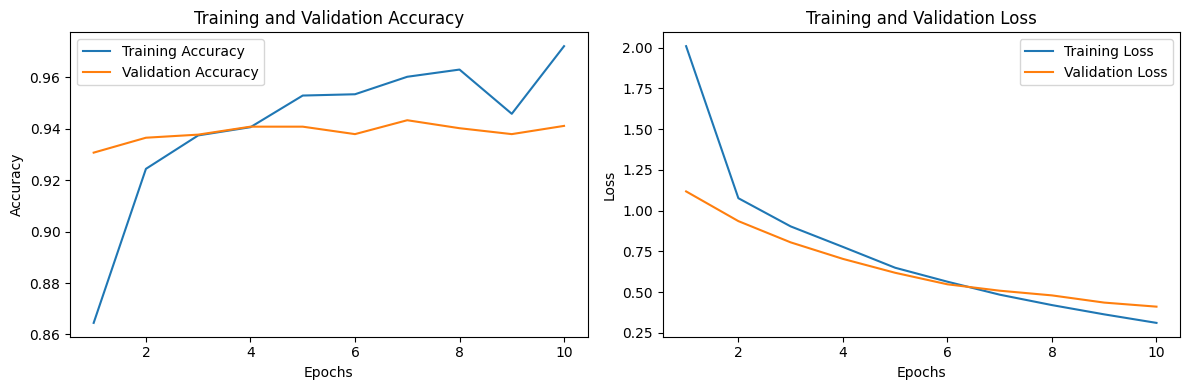

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Check the current working directory
print("Current working directory:", os.getcwd())

# Check if the model file exists
model_path = 'my_model_resnet50.h5'
if os.path.exists(model_path):
    print(f"Model found at {model_path}")
else:
    print(f"Model not found at {model_path}")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/AI/Skin Cancer/resnet50_melanoma_classifier.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'test_steps' is not defined

In [ ]:
predictions = loaded_model.predict(test_generator, steps=112)

112/112 ━━━━━━━━━━━━━━━━━━━━ 572s 5s/step


In [ ]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
convert = lambda x : 1 if x[1] == 1. else 0
test_labelsconf = list(map(convert, test_labels))

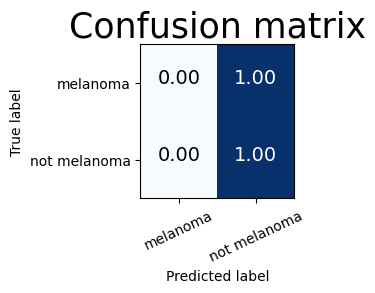

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, predicted):

    cm = confusion_matrix(actual, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(2,2))
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=25)

    tick_marks = np.arange(2)
    classes = ['melanoma', 'not melanoma']
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# Convert to a NumPy array
plot_confusion_matrix(test_labelsconf, predicted_classes)